In [ ]:
!pip install openai langgraph langchain-core

In [2]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [4]:
from typing import TypedDict
from langgraph.graph import StateGraph, END
from openai import OpenAI

client = OpenAI()

### Define Agent State

In [5]:
class AgentState(TypedDict):
    email_text: str
    days_waiting: int
    decision: str
    followup_mail: str

### Node 1: Analyze Need for Follow-Up

In [6]:
def analyze_followup(state: AgentState):

    prompt = f"""
    You are a work email assistant.

    Email:
    {state['email_text']}

    Days without reply: {state['days_waiting']}

    Decide:
    - Follow-Up Needed
    - Wait
    - Urgent Follow-Up

    Answer only one label.
    """

    response = client.chat.completions.create(
        model="gpt-4.1-mini",
        messages=[{"role":"user","content":prompt}]
    )

    state["decision"] = response.choices[0].message.content.strip()
    return state

### Node 2: Generate Follow-Up Mail

In [7]:
def generate_followup(state: AgentState):

    if "Wait" in state["decision"]:
        state["followup_mail"] = "No follow-up needed now."
        return state

    prompt = f"""
    Write a short professional follow-up email.

    Context:
    {state['email_text']}

    Tone:
    Simple, polite, engineering work environment.
    """

    response = client.chat.completions.create(
        model="gpt-4.1-mini",
        messages=[{"role":"user","content":prompt}]
    )

    state["followup_mail"] = response.choices[0].message.content
    return state

### Build Agent Workflow (LangGraph)

In [8]:
workflow = StateGraph(AgentState)

workflow.add_node("analyze", analyze_followup)
workflow.add_node("generate", generate_followup)

workflow.set_entry_point("analyze")
workflow.add_edge("analyze", "generate")
workflow.add_edge("generate", END)

app = workflow.compile()

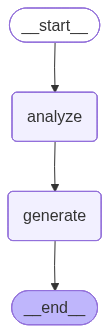

In [9]:
app

### Run the Agent

In [11]:
input_data = {
    "email_text": """
Hi Vijay,
Please share new model test report number for finaize decision.
Waiting for your update.
""",
    "days_waiting": 5
}

result = app.invoke(input_data)

print("Decision:", result["decision"])
print("\nGenerated Follow-Up Mail:\n")
print(result["followup_mail"])

Decision: Follow-Up Needed

Generated Follow-Up Mail:

Subject: Follow-up on New Model Test Report Number

Hi Vijay,

I hope you are doing well. I wanted to kindly follow up on the new model test report number to help finalize the decision.

Please share the update at your earliest convenience.

Thank you.

Best regards,  
[Your Name]
